In [5]:
import numpy as np
import sys
sys.path.insert(0, '/Library/Application Support/MWorks/Scripting/Python')
from mworks.data import MWKFile
import matplotlib.pyplot as plt
import matplotlib.style as style 
import pandas as pd
from scipy.stats import linregress

style.use('seaborn-poster') 
style.use('seaborn-white')

In [6]:
username = 'aidapiccato'
dir_path = '/Users/%s/PyCharmProjects/concentration/concentration-game-mworks' % username
subject_id = 0

In [7]:
## sync times 
ITI = 1
TRIAL_INIT = 2
FLIP_CARD_A = 3
FLIP_CARD_B = 4
FEEDBACK = 5
TRIAL_END = 6

In [440]:
class Unpack():    
    def __init__(self, fns):
        fpath = '/Users/%s/Documents/MWorks/Data' % username
        self.fns = fns        
        self.codenames = ['card_b', 'card_a',  'grid', 'grid_dims', 'inv_grid', 'n_pairs', 'block_index', 'trial_index', 'feedback_dur', 'trial_in_block_index'] 
        data_scalar = {'dur': [], 'card_a_img': [], 'card_b_img': [], 'card_c': [], 'dist_a_b': [], 'dist_b_c': [], 'trial_index': [], 'rt': [], 'card_a_t': [], 'card_b_t': [], 'theta_a_c': [], 'dist_a_c': [], 'success': []} 
        for c in self.codenames:
            data_scalar[c] = []
        self.start_sync_t, self.end_sync_t = np.asarray([]), np.asarray([])
        self.n_trials = 0
        self.scalar = pd.DataFrame({})
        for fn in fns:
            f =  MWKFile('%s/%s' % (fpath, fn))
            f.open()
            codec = f.codec            
            start, end = self.get_sync_times(f)
            self.start_sync_t = np.concatenate((self.start_sync_t, start))
            self.end_sync_t   = np.concatenate((self.end_sync_t, end))
            self.get_scalar_data(f, start, end, data_scalar)         
            f.close()
        self.scalar = pd.DataFrame(data_scalar)
        self.n_trials = len(self.start_sync_t)
        print('Collecting %d trials of data' % self.n_trials)
        self.avg_trial_dur = (self.end_sync_t - self.start_sync_t) / 10**6
        print('Average trial duration: %f seconds' % np.mean(self.avg_trial_dur))
        print('Total session duration: %f minutes' % (int(self.scalar.dur.sum())/60))
            
        
    def pool_across_days(self): 
        """
        Pool data from same subject across days
        """
                
    def get_scalar_data(self, f, start_sync_t, end_sync_t, data_scalar):
        n_trials = len(start_sync_t)
        orig_len = len(data_scalar['success'])
        for i_trial in range(n_trials):            
            trial = i_trial + orig_len
            start_t, end_t = np.long(start_sync_t[i_trial]), np.long(end_sync_t[i_trial])
            trial_events = f.get_events(codes = self.codenames, time_range=[start_t, end_t])
            trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])         
            # trial duration        
            data_scalar['dur'].append((end_t - start_t)/10**6)        
            for ci, c in enumerate(self.codenames): # currently this is only selecting card_b                
                code = f.reverse_codec[c]
                code_events = trial_events[np.where(trial_events[:, 0] == code)[0], 2]
                if (len(code_events) == 0):
                    data_scalar[c].append(None)
                else:
                    data_scalar[c].append(code_events[0])                    
            
            card_a = data_scalar['card_a'][trial]
            card_b = data_scalar['card_b'][trial]
            grid = np.asarray(data_scalar['grid'][trial])
            match = np.where(grid == grid[card_a])[0]            
            card_c = match[match != card_a]                
            data_scalar['success'].append(card_c[0] == card_b)
            if(data_scalar['success'][trial] == 0 and card_c[0] == card_b): print(trial, data_scalar['success'][trial])
            data_scalar['card_c'].append(card_c[0])
            
            data_scalar['card_a_img'].append(data_scalar['grid'][trial][card_a])
            data_scalar['card_b_img'].append(data_scalar['grid'][trial][card_b])
            
            # distance between locations of card a and b
            data_scalar['dist_a_b'].append(self.get_dist(card_a, card_b, data_scalar['grid_dims'][trial]))
            
            # distance between locations of card b and correct card
            data_scalar['dist_b_c'].append(self.get_dist(card_b, card_c, data_scalar['grid_dims'][trial]))   
            
            # distance between locations of card b and correct card
            data_scalar['dist_a_c'].append(self.get_dist(card_a, card_c, data_scalar['grid_dims'][trial]))   

            data_scalar['card_b_t'].append(self.get_t_trial(FLIP_CARD_B, f, start_t, end_t))
            
            data_scalar['theta_a_c'].append(self.get_angle(card_a, card_c, data_scalar['grid_dims'][trial]))
            
        data_scalar['rt'] = np.concatenate((data_scalar['rt'], self.get_reaction_times(f, n_trials, start_sync_t, end_sync_t)))
        data_scalar['card_a_t'] = np.concatenate((data_scalar['card_a_t'], self.get_t(FLIP_CARD_A, f, n_trials)))
    
    def get_t_trial(self, sync, f, start_t, end_t):
        trial_events = f.get_events(codes = ['sync'], time_range=[start_t, end_t])
        trial_events = np.asarray([[e.code, e.time, e.data] for e in trial_events])
        trial_events = trial_events[np.where(trial_events[:, 2] == sync)[0], 1]
        if (len(trial_events) == 0):
            return None
        else:
            return trial_events[0]
    
    def get_t(self, sync, f, n_trials):
        sync_events = f.get_events(codes = ['sync'])
        sync_events = np.asarray([[e.code, e.time, e.data] for e in sync_events])
        sync_events = sync_events[np.where(sync_events[:, 2] == sync)[0], 1]
        return sync_events[:n_trials]

    
    def get_analog_data(self):
        data_analog = {'card': [], 'trial_in_block_index': [], 'trial_index': [], 'time': [], 'block_index': [], 'flipped': []} 
        
        for t in range(self.n_trials):
            start_t, end_t = np.long(self.start_sync_t[t]), np.long(self.end_sync_t[t])
            card_a_t = self.scalar['card_a_t'][t]
            card_b_t = self.scalar['card_b_t'][t]
            
            data_analog['card'].append(self.scalar['card_a'][t])
            
            data_analog['trial_in_block_index'].append(self.scalar['trial_in_block_index'][t])
            data_analog['trial_index'].append(t)
            data_analog['time'].append(card_a_t)
            data_analog['block_index'].append(self.scalar['block_index'][t])
            data_analog['flipped'].append(False)
            
            
            if card_b_t != None:
                data_analog['card'].append(self.scalar['card_b'][t])
                data_analog['trial_in_block_index'].append(self.scalar['trial_in_block_index'][t])
                data_analog['time'].append(card_b_t)         
                data_analog['trial_index'].append(t)
                data_analog['block_index'].append(self.scalar['block_index'][t])
                data_analog['flipped'].append(True)
                        
        data_analog = pd.DataFrame(data_analog)    
        data_analog.reset_index(inplace=True)
                                               
        return data_analog
    
    def get_sync_times(self, f): 
        sync_events = f.get_events(codes=['sync'])
        sync_events = np.asarray([[e.data, e.time] for e in sync_events])        
        end_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_END)[0], 1]
        start_sync_t = sync_events[np.where(sync_events[:, 0] == TRIAL_INIT)[0], 1]
        start_sync_t = start_sync_t[:len(end_sync_t)]
        return start_sync_t, end_sync_t
    
    def get_angle(self, card_a, card_b, grid_dims):
        card_a_loc = np.squeeze(np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]]))
        card_b_loc = np.squeeze(np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]]))
        vector_ab = (card_b_loc - card_a_loc)
        vector_0 = np.asarray([1, 0])
        return np.arccos(np.dot(vector_ab, vector_0)/(np.linalg.norm(vector_0) * np.linalg.norm(vector_ab))) * 180 / np.pi
    
    def get_dist(self, card_a, card_b, grid_dims): 
        card_a_loc = np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]])
        card_b_loc = np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]])
        return np.linalg.norm(card_a_loc - card_b_loc)
    
    def get_reaction_times(self, f, n_trials, start_sync_t, end_sync_t):
        rts = []
        for trial in range(n_trials):
            start_t, end_t = np.long(start_sync_t[trial]), np.long(end_sync_t[trial])
            sync = f.get_events(codes = ['sync'], time_range=[start_t, end_t])
            sync = np.asarray([[e.data, e.time] for e in sync])                
            flip_card_a = sync[np.where(sync[:, 0] == FLIP_CARD_A)[0], 1]
            flip_card_b = sync[np.where(sync[:, 0] == FLIP_CARD_B)[0], 1]                    
            if len(flip_card_b) == 0:
                flip_card_b = [flip_card_a]
            rt = np.long(flip_card_b[0]) - np.long(flip_card_a[0])
            rts.append(rt/10**6)
        return rts

In [441]:
fn = ["aidapiccato-concentration-ios-20200127-142123.mwk2", "aidapiccato-concentration-ios-20200127-111036.mwk2"]
unpack = Unpack(fn)

here
here
Average trial duration: 1.784731 seconds
Total session duration: 49.583333 minutes


In [855]:
class Analysis:
    def __init__(self, unpack):
        self.scalar = unpack.scalar
        self.card_views = unpack.get_analog_data()
        self.spatial_dist = self.get_spatial_dist()
        self.temporal_dist = self.get_temporal_dist()
        self.n_trials = len(self.scalar)        
        
    def get_spatial_dist(self):
        spatial_dist = pd.DataFrame()
        spatial_dist['dist_a_b'] = self.scalar.apply(lambda t: self.get_dist_norm(t.card_a, t.card_b, t.grid_dims), 
                                                     axis=1)
        spatial_dist['dist_a_c'] = self.scalar.apply(lambda t: self.get_dist_norm(t.card_a, t.card_c, t.grid_dims), 
                                                     axis=1)
        spatial_dist['dist_b_c'] = self.scalar.apply(lambda t: self.get_dist_norm(t.card_b, t.card_c, t.grid_dims), 
                                                     axis=1)
        return spatial_dist
    
    def get_temporal_dist(self):
        temporal_dist = pd.DataFrame()
        # number of cards since card_c was last seen
        temporal_dist['n_imgs_c'] = self.scalar.apply(lambda t: self.get_t_dist_disc(t.card_c, t.trial_in_block_index,
                                                                                    t.block_index), axis=1)      
        
        # time since card_c was last seen
        temporal_dist['t_c'] = self.scalar.apply(lambda t: self.get_t_dist_cont(t.card_c, t.card_a_t, t.trial_in_block_index, \
                                                                                t.block_index), axis=1)
        # time since card_b was last seen
        temporal_dist['t_b'] = self.scalar.apply(lambda t: self.get_t_dist_cont(t.card_b, t.card_a_t, t.trial_in_block_index, \
                                                                                t.block_index), axis=1)
              
        # number of cards since card_b was last seen
#         temporal_dist['n_imgs_b'] = self.scalar.apply(lambda t: self.get_t_dist_disc(t.card_b, t.trial_index, 
#                                                                                     t.block_index), axis=1)                 
        return temporal_dist
        
    def get_t_dist_cont(self, card, card_a_t, trial_in_block_index, block_index):     
        last_t = self.card_views[self.card_views.card.eq(card) & self.card_views.block_index.eq(block_index) & 
                                 self.card_views.trial_in_block_index.lt(trial_in_block_index)]
        if len(last_t) > 0:
            return card_a_t - last_t.iloc[-1].time
        return -1    
    
    def get_t_dist_disc(self, card, trial_in_block_index, block_index):
        
        last_t = self.card_views[self.card_views.card.eq(card) & self.card_views.block_index.eq(block_index) & 
                                 self.card_views.trial_in_block_index.lt(trial_in_block_index)]
        
        curr_t = self.card_views[self.card_views.block_index.eq(block_index) & 
                                 self.card_views.trial_in_block_index.eq(trial_in_block_index)].iloc[0]
        

        if len(last_t) > 0:
            return curr_t['index'] - last_t.iloc[-1]['index']
        
        return -1
        
    def get_dist_norm(self, card_a, card_b, grid_dims): 
        card_a_loc = np.asarray([np.floor(card_a/grid_dims[1]), card_a%grid_dims[1]])
        card_b_loc = np.asarray([np.floor(card_b/grid_dims[1]), card_b%grid_dims[1]])
        max_dist = np.linalg.norm(np.asarray([4, 4]))
        return np.linalg.norm(card_a_loc - card_b_loc)/max_dist

In [856]:
unpack.scalar['trial_index'] = np.arange(len(unpack.scalar))

In [857]:
a = Analysis(unpack)

***

**Sanity check for distance between a and c**  
Some distance pairs never occur, which is why there are white spots. However, distance function is working correctly - closest pairs are along the diagonal

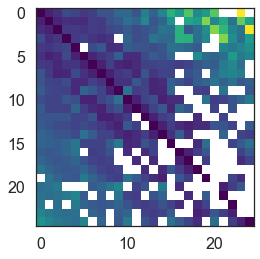

In [442]:
df = pd.concat([a.spatial_dist.dist_a_c, a.scalar.card_a, a.scalar.card_c, a.scalar.n_pairs], axis=1)
plt.imshow(df.groupby(['card_a', 'card_c'])['dist_a_c'].apply(np.mean).unstack(), cmap='viridis')
plt.show()

**Sanity check for success values**  
Making sure these are all trials in which card b is equal to card c

In [452]:
df = pd.concat([a.scalar.success, a.scalar.card_b, a.scalar.card_c], axis=1)
success = df[df.card_b == df.card_c]
failure = df[df.card_c != df.card_b]
print(len(success[success.success == 1])/len(success))
print(len(failure[failure.success == 0])/len(failure))

1.0
1.0


***

**Plotting prob. of correct choice as a function of distance and angle between card a and card c**

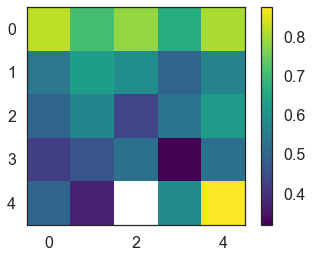

In [884]:
df = pd.concat([a.spatial_dist.dist_a_c, a.scalar.success, a.scalar.theta_a_c], axis=1)
n_bins_dist, n_bins_theta = 5, 5
df['dist_a_c_bin'] = pd.cut(df.dist_a_c, n_bins_dist)
df['theta_a_c_bin'] = pd.cut(df.theta_a_c, n_bins_theta)
df = df.groupby(['dist_a_c_bin', 'theta_a_c_bin'])['success'].apply(np.mean).dropna()
plt.imshow(df.unstack(), cmap='viridis')
plt.colorbar()

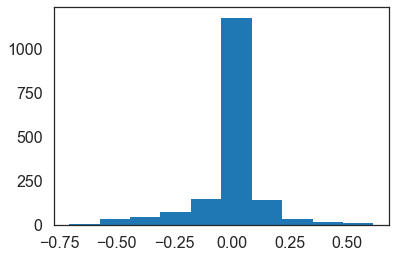

In [896]:
df = pd.concat([a.spatial_dist.dist_a_b, a.spatial_dist.dist_a_c, a.scalar.success], axis=1)
plt.hist(df.dist_a_b - df.dist_a_c)
plt.show()

**Plotting probability of correct choice as a function of distance between card a and card c**

In [907]:
df.groupby('dist_a_c_bin')['success'].apply(np.mean).dropna().values

array([0.7969697 , 0.6875    , 0.55555556, 0.57507987, 0.5625    ,
       0.4375    , 0.57608696, 0.41964286, 0.53125   , 0.5       ,
       0.6875    , 0.4375    ])

In [999]:
df.groupby(['dist_a_c_bin'])['success'].apply(np.mean)

dist_a_c_bin
(0.0, 0.0982]           NaN
(0.0982, 0.196]    0.796970
(0.196, 0.295]     0.687500
(0.295, 0.393]     0.555556
(0.393, 0.491]     0.575080
(0.491, 0.589]     0.547222
(0.589, 0.687]     0.419643
(0.687, 0.786]     0.520833
(0.786, 0.884]     0.562500
Name: success, dtype: float64

-0.35277156775890806 0.5615810306240175


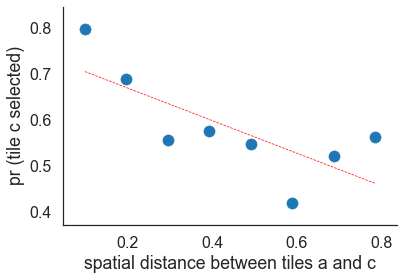

In [1022]:
df = pd.concat([a.spatial_dist.dist_a_c, a.scalar.success], axis=1)
n_bins = 10
bins = np.linspace(0, np.amax(df.dist_a_c), n_bins)
df['dist_a_c_bin'] = pd.cut(df.dist_a_c, bins)
plt.scatter(bins[:-1], df.groupby(['dist_a_c_bin'])['success'].apply(np.mean))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(bins[1:-1],df.groupby(['dist_a_c_bin'])['success'].apply(np.mean).dropna())
y = intercept + slope * bins[1:-1]
plt.plot(bins[1:-1], y, 'r--', linewidth=0.7)
print(slope, r_value**2)
plt.xlabel('spatial distance between tiles a and c')
plt.ylabel('pr (tile c selected)')
prettify(plt.gca())
plt.show()

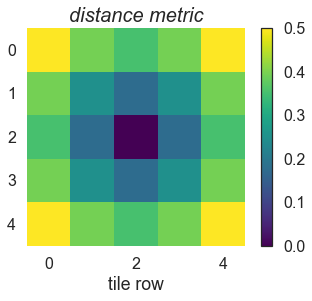

In [956]:
i = 12
grid_dims = [5, 5]
card_a_loc = np.asarray([np.floor(i/grid_dims[1]), i%grid_dims[1]])
dists = np.zeros(grid_dims)
for j in range(25):
    if j != i:
        j_loc = np.asarray([np.floor(j/grid_dims[1]), j%grid_dims[1]], dtype=int)
        dists[j_loc[0], j_loc[1]] = a.get_dist_norm(i, j, grid_dims)
#         print(i, j, a.get_dist_norm(i, j, grid_dims))
plt.imshow(dists, cmap='viridis')
plt.title('distance metric')
plt.colorbar()
prettify(plt.gca())
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xlabel('tile column')
plt.xlabel('tile row')
plt.show()

**Plotting probability of correct choice as a function of temporal distance**

In [909]:
df.groupby('t_c_bin')['success'].value_counts()

t_c_bin             success
(0.0, 8.07]         True       503
                    False       93
(8.07, 16.14]       True       219
                    False      105
(16.14, 24.21]      True        97
                    False       64
(24.21, 32.28]      False       66
                    True        60
(32.28, 40.35]      True        49
                    False       35
(40.35, 48.42]      True        27
                    False       20
(48.42, 56.49]      False       18
                    True         9
(56.49, 64.56]      False       18
                    True        14
(64.56, 72.63]      True         6
                    False        5
(72.63, 80.7]       False       12
                    True         4
(80.7, 88.77]       False        7
                    True         2
(88.77, 96.841]     False        3
                    True         3
(96.841, 104.911]   False        4
                    True         1
(104.911, 112.981]  False        3
(112.981, 121.051]  False  

-0.005628429722630029 0.853056571773055


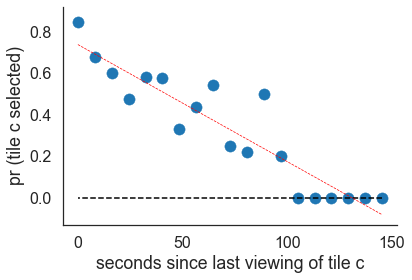

In [1021]:
df = pd.concat([a.temporal_dist.t_c, a.scalar.success], axis=1)
# time since card c last seen
df = df[df.t_c != -1]
df.t_c = df.t_c / 10**6
n_bins = 20
bins = np.linspace(0, df.t_c.max(), n_bins)
df['t_c_bin']= pd.cut(df.t_c, bins=bins)
plt.scatter(bins[:-1], df.groupby('t_c_bin')['success'].mean().dropna())
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(bins[:-1], df.groupby('t_c_bin')['success'].mean().dropna())
y = intercept + slope * bins[:-1]
plt.plot(bins[:-1], y, 'r--', linewidth=0.7)
print(slope, r_value**2)
plt.hlines(0, bins[-2], [0], linestyle='--', linewidth=1.5)
plt.xlabel('seconds since last viewing of tile c')
plt.ylabel('pr (tile c selected)')
prettify(plt.gca())
# df.groupby('t_c_bin')['success'].apply(np.mean).dropna()
# df.groupby('t_c_bin')['success'].apply(len)

-0.006659148412005497 0.9020706136249325


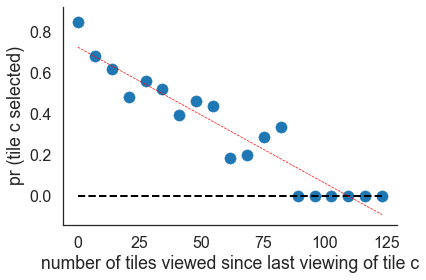

In [1020]:
df = pd.concat([a.temporal_dist.n_imgs_c, a.scalar.success], axis=1)
df = df[df.n_imgs_c != -1]
n_bins = 20
bins = np.linspace(0, 130, n_bins)
df['n_imgs_c_bin'] = pd.cut(df.n_imgs_c, bins)
plt.scatter(bins[:-1], df.groupby('n_imgs_c_bin')['success'].mean())
plt.hlines(0, np.amax(bins[:-1]), [0], linestyle='--', linewidth=2)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(bins[:-1], df.groupby('n_imgs_c_bin')['success'].mean().dropna())
y = intercept + slope * bins[:-1]
print(slope, r_value ** 2)
plt.plot(bins[:-1], y, 'r--', linewidth=0.7)
plt.ylabel('pr (tile c selected)')
plt.xlabel('number of tiles viewed since last viewing of tile c')
prettify(plt.gca())

**Plotting temporal distance forgetting for each block**


2
4
8
12


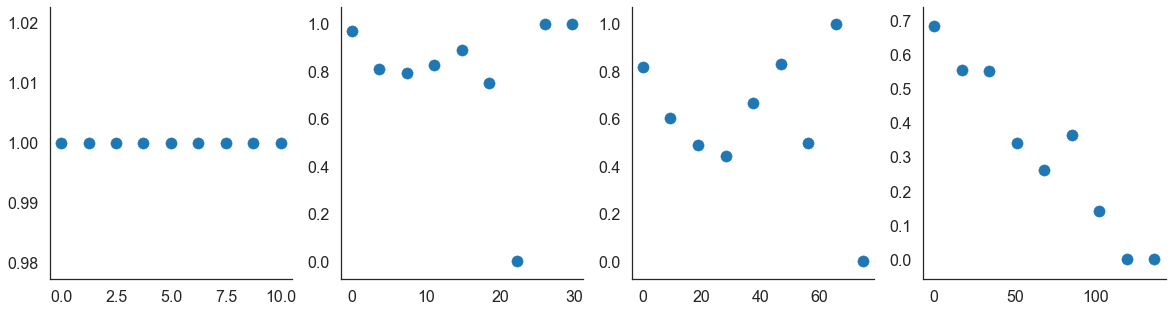

In [985]:
df = pd.concat([a.temporal_dist.t_c, a.scalar.success, a.scalar.n_pairs], axis=1)
df = df[df.t_c != -1]
df.t_c = df.t_c / 10**6
n_bins = 10
df['t_c_bin']= pd.cut(df.t_c, bins=bins)
grouped = df.groupby(['n_pairs'])
f, axs = plt.subplots(1, 4, figsize = (20, 5))
for x, (i, group) in enumerate(grouped):
    print(i)
    group = pd.DataFrame(group)
    bins = np.linspace(0, group.t_c.max(), n_bins)
    group['t_c_bin']= pd.cut(group.t_c, bins=bins)
    axs[x].scatter(bins[:-1], group.groupby('t_c_bin')['success'].apply(np.mean))
    prettify(axs[x])
# plt.scatter(bins[:-1], df.groupby('n_imgs_c_bin')['success'].mean())
# plt.hlines(0, np.amax(bins[:-1]), [0], linestyle='--', linewidth=2)
# plt.ylabel('pr (tile c selected)')
# plt.xlabel('number of tiles viewed since last viewing of tile c')
# prettify(plt.gca())

**Plotting probability of selecting correct card as a function of time since card last seen and distance from card c to card a**

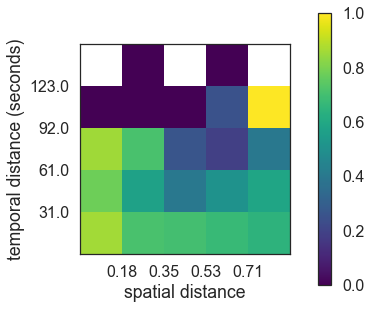

In [1024]:
df = pd.concat([a.temporal_dist.t_c, a.spatial_dist.dist_a_c, a.scalar.success], axis=1)
df.t_c = df.t_c / 10**6
n_bins = 6
t_bins = np.linspace(0, np.amax(df.t_c), n_bins)
df['t_c_bin'] = pd.cut(df.t_c, bins = t_bins)
s_bins = np.linspace(0, np.amax(df.dist_a_c), n_bins)
df['dist_a_c_bin'] = pd.cut(df.dist_a_c, bins=s_bins)
df = df.groupby(['t_c_bin', 'dist_a_c_bin'])['success'].apply(np.mean)
f, ax = plt.subplots(1, 1, figsize=(5, 5))
c = ax.imshow(df.unstack(), cmap='viridis', origin='lower', interpolation = 'none')
ax.set_xticks(np.linspace(0, 4, 4, endpoint=False)+0.5)
ax.set_xticklabels(np.round(s_bins, decimals=2)[1:])
ax.set_xlabel('spatial distance')
ax.set_yticks(np.linspace(0, 4, 4, endpoint=False)+0.5)
ax.set_yticklabels(np.round(t_bins)[1:])
ax.set_ylabel('temporal distance (seconds)')
ax.set_aspect('equal')
f.colorbar(c, ax=ax, pad=0.1)
plt.show()

# Higher-level performance measures
- Average percentage successful trials for each block size 

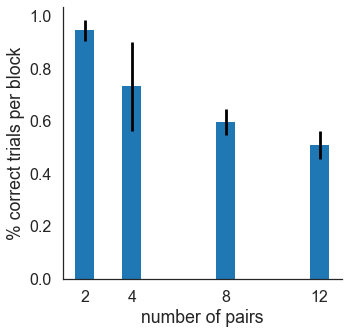

In [648]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
n_pairs = np.sort(unpack.scalar['n_pairs'].unique())
mean = unpack.scalar.groupby(['n_pairs', 'block_index'])['success'].apply(np.mean).mean(level=0)
std =  unpack.scalar.groupby(['n_pairs', 'block_index'])['success'].apply(np.mean).std(level=0)
ax.bar(n_pairs, mean, yerr=std)
ax.set_xticks(np.sort(unpack.scalar['n_pairs'].unique()))
ax.set_xlabel('number of pairs')
ax.set_ylabel('% correct trials per block')
prettify(ax)
plt.show()

- $Pr (selecting correct card)$ over time, averaged across blocks of the same size (learning trajectory)

Text(142.55, 0.5, 'pr (correct tile selected)')

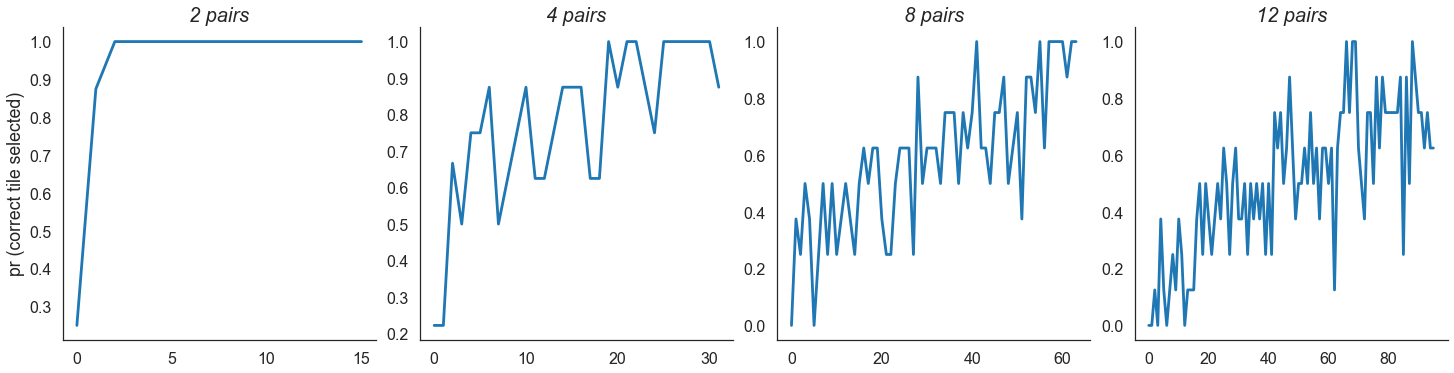

In [659]:
df = pd.concat([a.scalar.success, a.scalar.n_pairs, a.scalar.trial_in_block_index], axis=1)
df = df.groupby(['n_pairs', 'trial_in_block_index'])['success'].apply(np.mean).unstack()
nrows, ncols = 1, 4
f, axs = plt.subplots(nrows, ncols, figsize=(20, 5))
max_n_trials = 12 * 2 * 3
for i, k in enumerate([2, 4, 8, 12]):
    group = pd.DataFrame(group)
    n_trials = k * 2 * 4
    axs[i].plot(np.arange(n_trials), df.iloc[i, :n_trials].values, label=k) 
plt.tight_layout()
for i, ax in enumerate(axs):
    ax.set_title('%d pairs' % ([2, 4, 8, 12][i]))
    prettify(ax)
axs[0].set_ylabel('pr (correct tile selected)')


- Distance of selected card from correct, averaged across blocks of the same size 

Text(133.675, 0.5, 'dist. between tiles b and c')

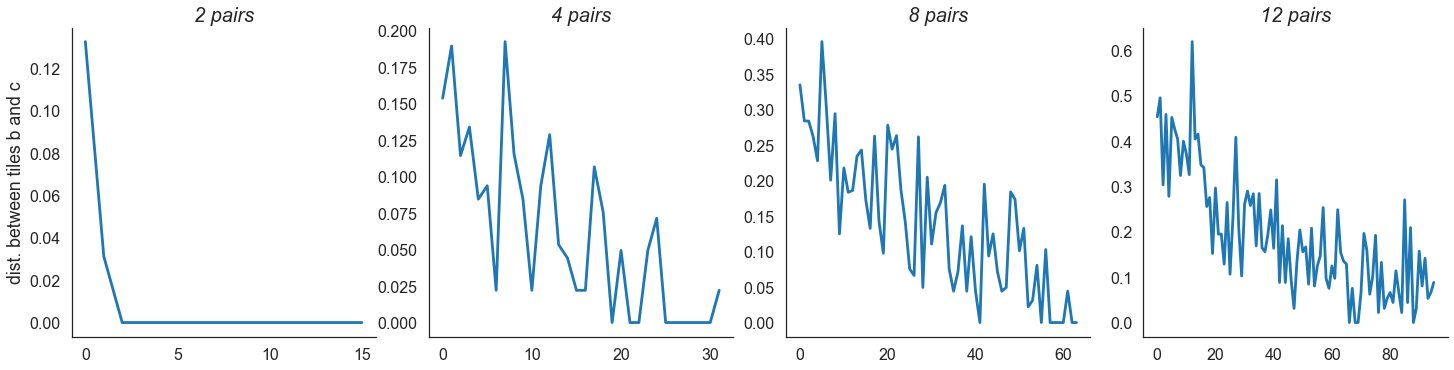

In [878]:
df = pd.concat([a.spatial_dist.dist_b_c, a.scalar.n_pairs, a.scalar.trial_in_block_index], axis=1)
df = df.groupby(['n_pairs', 'trial_in_block_index'])['dist_b_c'].apply(np.mean).unstack()
nrows, ncols = 1, 4
f, axs = plt.subplots(nrows, ncols, figsize=(20, 5))
max_n_trials = 12 * 2 * 3
for i, k in enumerate([2, 4, 8, 12]):
    group = pd.DataFrame(group)
    n_trials = k * 2 * 4
    axs[i].plot(np.arange(n_trials), df.iloc[i, :n_trials].values, label=k) 
plt.tight_layout()
for i, ax in enumerate(axs):
    ax.set_title('%d pairs' % ([2, 4, 8, 12][i]))
    prettify(ax)
axs[0].set_ylabel('dist. between tiles b and c')